In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_text

import warnings
warnings.filterwarnings("ignore")

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")


## Preprocess the data by scaling

In [2]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

## Function to plot boxplots

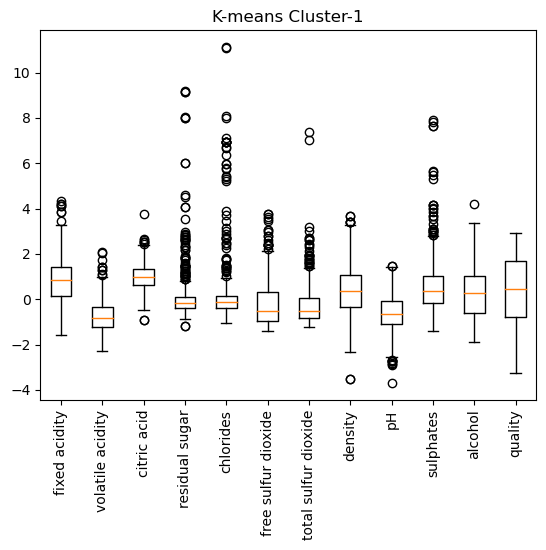

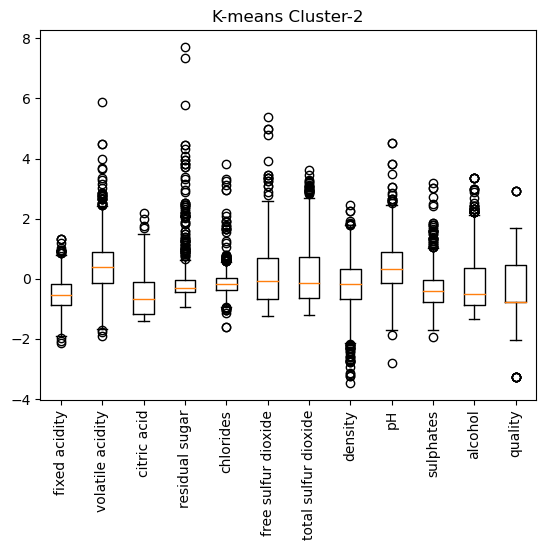

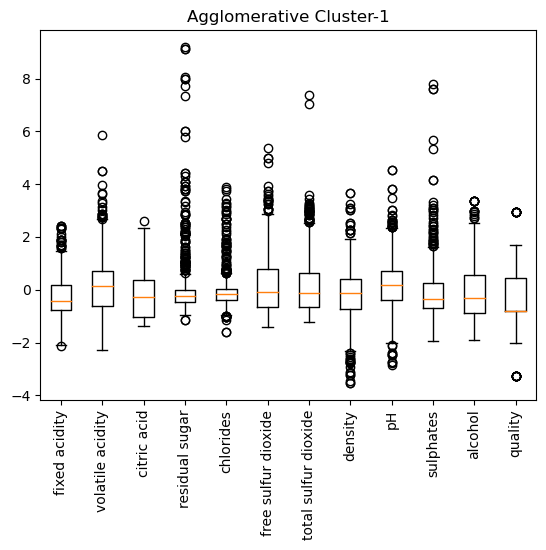

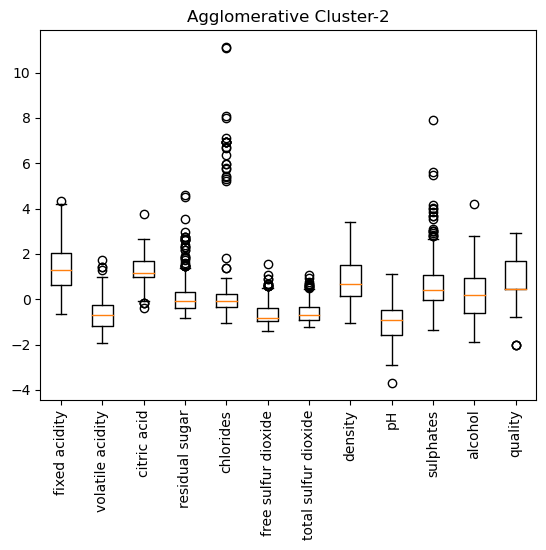

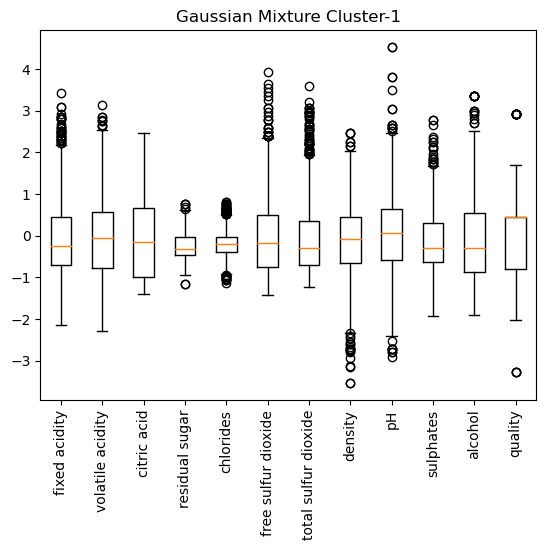

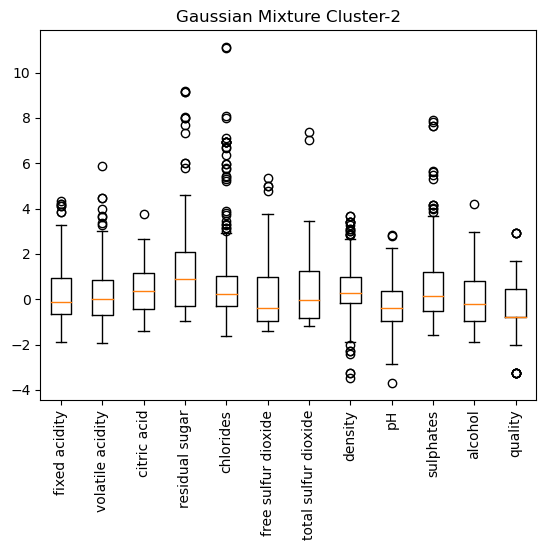

In [3]:
def plot_wine_boxplots(cluster_labels, data, cluster_name):
    unique_labels = np.unique(cluster_labels)
    num_clusters = len(unique_labels)

    for i in range(num_clusters):
        idx_cluster = np.where(cluster_labels == i)
        plt.figure()
        plt.title(f'{cluster_name} Cluster-{i+1}')
        plt.xticks(rotation=90)
        rows = idx_cluster[0].tolist()

        # Use all columns of the Wine Quality dataset
        plt.boxplot(data[np.ix_(rows, list(range(data.shape[1])))] ,
                    labels=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                            'pH', 'sulphates', 'alcohol', 'quality'])

# Convert data to numpy arrays
wine_X = np.array(scaled_data)

# K-means clustering
wine_kmeans = KMeans(n_clusters=2)
wine_kmeans.fit(scaled_data)
wine_kmeans_labels = wine_kmeans.predict(scaled_data)

# Hierarchical clustering
wine_agg_clustering = AgglomerativeClustering(n_clusters=2)
wine_agg_labels = wine_agg_clustering.fit_predict(scaled_data)

# Gaussian Mixture clustering
wine_gmm = GaussianMixture(n_components=2)
wine_gmm.fit(scaled_data)
wine_gmm_labels = wine_gmm.predict(scaled_data)


# Call the 'plot_boxplots()' function for each clustering method
plot_wine_boxplots(wine_kmeans_labels, wine_X, 'K-means')
plot_wine_boxplots(wine_agg_labels, wine_X, 'Agglomerative')
plot_wine_boxplots(wine_gmm_labels, wine_X, 'Gaussian Mixture')

## K-means 

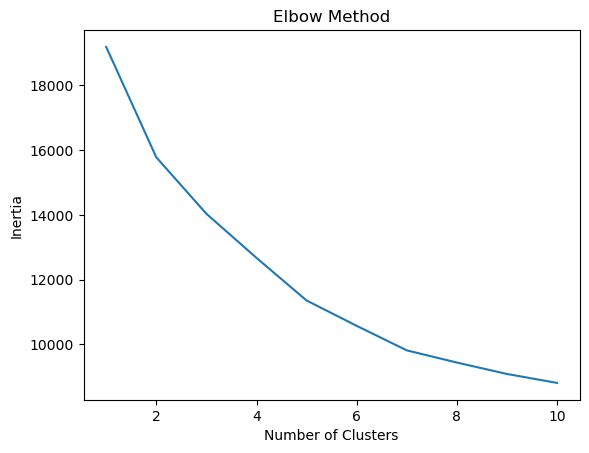

In [4]:
# Determine the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), inertia)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Choose the optimal number of clusters based on the plot
n_clusters = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(scaled_data)

In [5]:
# Cluster centroids
kmeans_centroids = kmeans.cluster_centers_
kmeans_centroids_df = pd.DataFrame(scaler.inverse_transform(kmeans_centroids), columns=data.columns)
print("K-means Cluster Centroids:")
print(kmeans_centroids_df)

# Number of samples in each cluster
kmeans_cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
print("\nK-means Cluster Sizes:")
print(kmeans_cluster_sizes)

K-means Cluster Centroids:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       8.203299          0.536142     0.290584        3.044036   0.087241   
1       9.969763          0.397233     0.467036        2.591008   0.098818   
2       7.190701          0.617661     0.117997        2.216237   0.079376   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            26.465736             87.934010  0.997305  3.284924   0.625863   
1            11.401186             31.191700  0.997433  3.198794   0.757688   
2            13.143777             34.153076  0.995935  3.407182   0.604292   

     alcohol   quality  
0   9.834222  5.276650  
1  10.829578  6.090909  
2  10.460515  5.509299  

K-means Cluster Sizes:
0    394
1    506
2    699
dtype: int64


## Hierarchical clustering

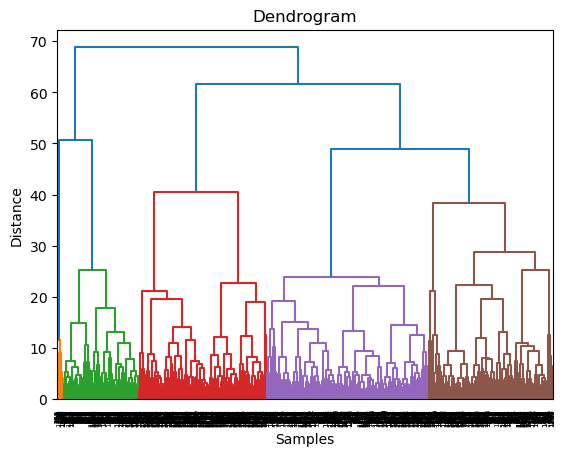

In [6]:
# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(scaled_data)

# Plot the dendrogram
Z = linkage(scaled_data, 'ward')
plt.figure()
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [7]:
# Number of samples in each cluster
agg_cluster_sizes = pd.Series(agg_labels).value_counts().sort_index()
print("\nAgglomerative Cluster Sizes:")
print(agg_cluster_sizes)


Agglomerative Cluster Sizes:
0    265
1    923
2    411
dtype: int64


## Gaussian Mixture

In [8]:
# Perform Gaussian Mixture clustering
gmm = GaussianMixture(n_components=n_clusters)
gmm_labels = gmm.fit_predict(scaled_data)

In [9]:
# Gaussian Mixture means
gmm_means = gmm.means_
gmm_means_df = pd.DataFrame(scaler.inverse_transform(gmm_means), columns=data.columns)
print("Gaussian Mixture Cluster Means:")
print(gmm_means_df)

# Gaussian Mixture covariances
gmm_covariances = gmm.covariances_
print("\nGaussian Mixture Cluster Covariances:")
for i, cov_matrix in enumerate(gmm_covariances):
    print(f"Cluster {i}:")
    print(pd.DataFrame(cov_matrix, columns=data.columns, index=data.columns))
    print()

# Number of samples in each cluster
gmm_cluster_sizes = pd.Series(gmm_labels).value_counts().sort_index()
print("\nGaussian Mixture Cluster Sizes:")
print(gmm_cluster_sizes)

Gaussian Mixture Cluster Means:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       8.360646          0.499277     0.262503        2.161091   0.077001   
1       8.384671          0.536977     0.308670        4.286330   0.089008   
2       8.096617          0.626451     0.263877        2.152591   0.125518   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            14.678505             34.102284  0.996615  3.325325   0.647261   
1            19.639544             62.845379  0.997056  3.316445   0.669700   
2            16.493074             76.289139  0.996923  3.251719   0.687392   

     alcohol   quality  
0  10.498373  5.743557  
1  10.933662  5.666986  
2   9.606226  5.196366  

Gaussian Mixture Cluster Covariances:
Cluster 0:
                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              0.982451         -0.261051     0.716383   
volatile acidity          -0.261051          0.8

## Scatter plots

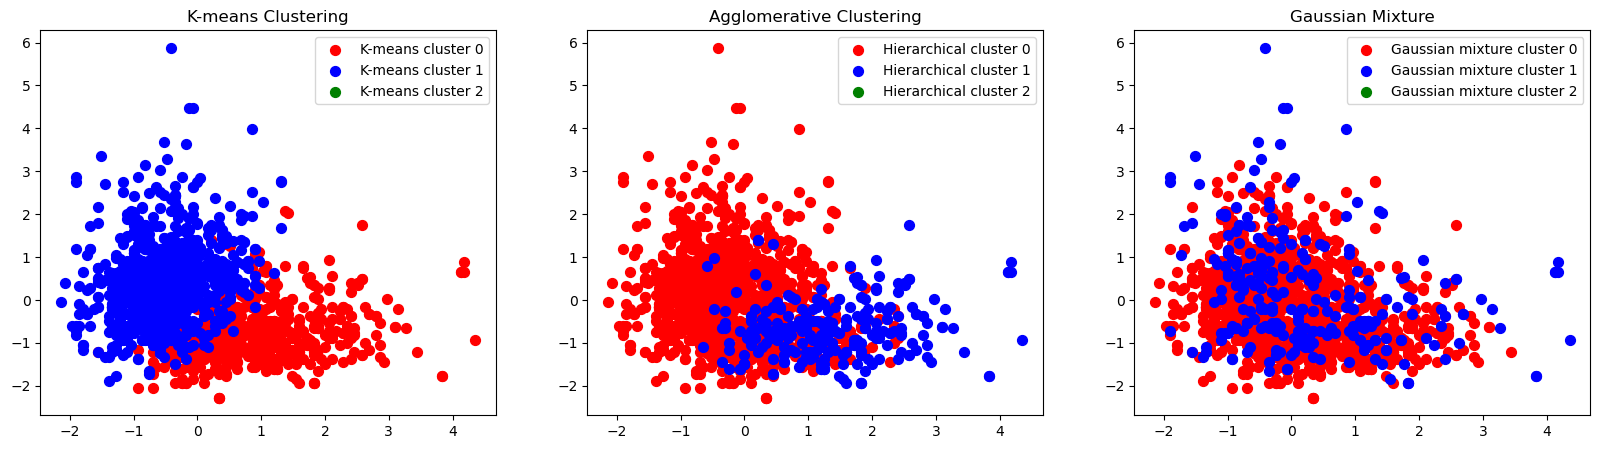

In [10]:
# Define the colors for the different clusters
colors = ['red', 'blue', 'green']

# Create a scatter plot of the data points with the cluster colors
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i in range(n_clusters):
    axes[0].scatter(scaled_data[wine_kmeans_labels == i, 0], scaled_data[wine_kmeans_labels == i, 1], s=50, c=colors[i], label='K-means cluster {}'.format(i))
    axes[1].scatter(scaled_data[wine_agg_labels == i, 0], scaled_data[wine_agg_labels == i, 1], s=50, c=colors[i], label='Hierarchical cluster {}'.format(i))
    axes[2].scatter(scaled_data[wine_gmm_labels == i, 0], scaled_data[wine_gmm_labels == i, 1], s=50, c=colors[i], label='Gaussian mixture cluster {}'.format(i))

axes[0].set_title("K-means Clustering")
axes[1].set_title("Agglomerative Clustering")
axes[2].set_title("Gaussian Mixture")

for ax in axes:
    ax.legend()

plt.show()


## Decision Trees

In [11]:
def evaluate_decision_trees(X, labels, feature_names):
    X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.3)

    clfDT = DecisionTreeClassifier()
    clfDT.fit(X_train, Y_train)

    print('Tree rules=\n', export_text(clfDT, feature_names=feature_names))

    Y_train_pred_DT = clfDT.predict(X_train)
    Y_test_pred_DT = clfDT.predict(X_test)

    confMatrixTrainDT = confusion_matrix(Y_train, Y_train_pred_DT)
    confMatrixTestDT = confusion_matrix(Y_test, Y_test_pred_DT)

    print('train: Confusion matrix Decision Tree')
    print(confMatrixTrainDT)
    print()

    print('test: Confusion matrix Decision Tree')
    print(confMatrixTestDT)
    print()

    print(classification_report(Y_test, Y_test_pred_DT))

feature_names = data.columns[:-1].tolist()  # Convert to list
wine_X_no_quality = np.array(scaled_data[:,:-1])

print("KMeans Clustering")
evaluate_decision_trees(wine_X_no_quality, wine_kmeans_labels, feature_names)

print("Agglomerative Clustering")
evaluate_decision_trees(wine_X_no_quality, wine_agg_labels, feature_names)

print("Gaussian Mixture")
evaluate_decision_trees(wine_X_no_quality, wine_gmm_labels, feature_names)


KMeans Clustering
Tree rules=
 |--- citric acid <= 0.33
|   |--- sulphates <= 0.16
|   |   |--- fixed acidity <= 0.94
|   |   |   |--- pH <= -1.53
|   |   |   |   |--- class: 0
|   |   |   |--- pH >  -1.53
|   |   |   |   |--- fixed acidity <= 0.82
|   |   |   |   |   |--- sulphates <= 0.04
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sulphates >  0.04
|   |   |   |   |   |   |--- citric acid <= 0.12
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- citric acid >  0.12
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- fixed acidity >  0.82
|   |   |   |   |   |--- citric acid <= -0.29
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- citric acid >  -0.29
|   |   |   |   |   |   |--- class: 1
|   |   |--- fixed acidity >  0.94
|   |   |   |--- citric acid <= -0.24
|   |   |   |   |--- class: 1
|   |   |   |--- citric acid >  -0.24
|   |   |   |   |--- class: 0
|   |--- sulphates >  0.16
|   |   |--- citric acid <= -0.39
| 